## 0. Loading Data and packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [3]:
#overriding default setting of pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
path = "/Users/angshumanchakraborty/Desktop/instacart-market-basket-analysis/"

In [5]:
orders = pd.read_csv(path + 'orders.csv')
products = pd.read_csv(path+ 'products.csv')
order_products_train = pd.read_csv(path+ 'order_products__train.csv')
order_products_prior = pd.read_csv(path+ 'order_products__prior.csv')
aisles = pd.read_csv(path+ 'aisles.csv')
departments = pd.read_csv(path+ 'departments.csv')

In [6]:
print('aisles shape :', aisles.shape)
print('departments shape :',departments.shape)
print('prior_order shape :', order_products_prior.shape)
print('train_order shape :', order_products_train.shape)
print('orders shape :', orders.shape)
print('products shape :', products.shape)

aisles shape : (134, 2)
departments shape : (21, 2)
prior_order shape : (32434489, 4)
train_order shape : (1384617, 4)
orders shape : (3421083, 7)
products shape : (49688, 4)


In [7]:
orders[(orders.eval_set=='prior') & (orders.user_id==2) ]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
11,2168274,2,prior,1,2,11,NaN
12,1501582,2,prior,2,5,10,10.0
13,1901567,2,prior,3,1,10,3.0
14,738281,2,prior,4,2,10,8.0
15,1673511,2,prior,5,3,11,8.0
16,1199898,2,prior,6,2,9,13.0
17,3194192,2,prior,7,2,12,14.0
18,788338,2,prior,8,1,15,27.0
19,1718559,2,prior,9,2,9,8.0
20,1447487,2,prior,10,1,11,6.0


##### Orders has 206209 unique users with 3-100 users per user. The users have been divided into train (131209) and test(75000)-the last order of any order (in orders) is classified as train and test and the rest as prior. Order product train has 131209 order IDs (with one order/user) and contains the product details for each order 

In [8]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [11]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [12]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## 1. Data Preprocessing & Exploratory Data Analysis

### Missing Values

In [13]:
#check missing values

print("Aisles missing:")  
print(aisles.isnull().sum(axis = 0))
print()

print("Departments missing:")
print(departments.isnull().sum(axis = 0))
print()

print("order_products__prior missing:")
print(order_products_prior.isnull().sum(axis = 0))
print()

print("order_products__train missing:")
print(order_products_train.isnull().sum(axis = 0))
print()

print("orders missing:")
print(orders.isnull().sum(axis = 0))
print()

print("products missing")
print(products.isnull().sum(axis = 0))
print()

Aisles missing:
aisle_id    0
aisle       0
dtype: int64

Departments missing:
department_id    0
department       0
dtype: int64

order_products__prior missing:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

order_products__train missing:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

orders missing:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

products missing
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64



In [14]:
# We convert character variables into category. 
# In Python, a categorical variable is called category and has a fixed number of different values
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [15]:
cnt_split = orders.eval_set.value_counts()
cnt_split

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

/Users/angshumanchakraborty/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


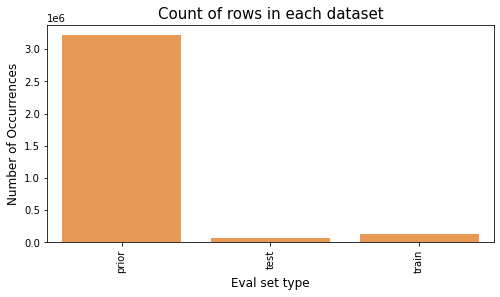

In [16]:
color = sns.color_palette()
plt.figure(figsize=(8,4))
sns.barplot(cnt_split.index, cnt_split.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [17]:
cnt_split = orders.groupby("eval_set")["user_id"].nunique()
cnt_split

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

#### Out of 206209 customers (all present in prior), the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

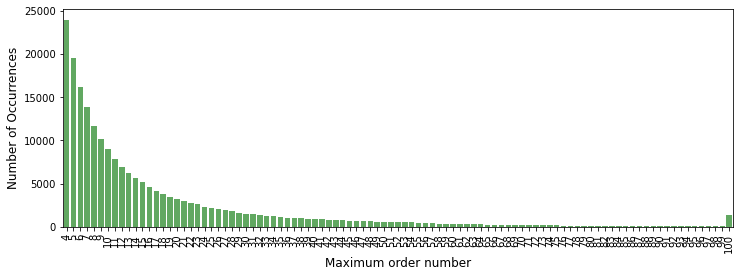

In [19]:
cnt_split = orders.groupby("user_id")["order_number"].max().reset_index()
cnt_split = cnt_split.order_number.value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_split.index, cnt_split.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

 #### Minimum no of orders by an user is 4 and is max capped at 100 

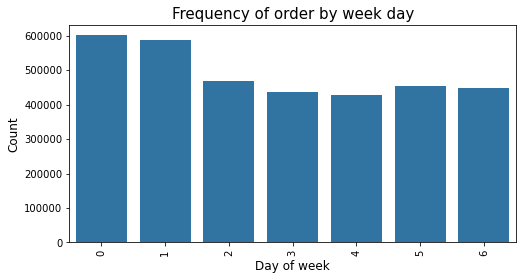

In [20]:
plt.figure(figsize=(8,4))
sns.countplot(x="order_dow", data=orders, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

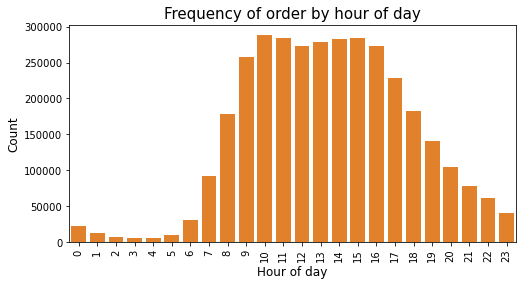

In [21]:
plt.figure(figsize=(8,4))
sns.countplot(x="order_hour_of_day", data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

In [22]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
grouped_df

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,48465,51035,51443,53849,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,55671,51584,47079,46728,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,39230,38128,35780,36650,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,36040,35215,33455,34161,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,35034,33857,32249,32751,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645
5,3189,1672,1016,841,910,1574,4866,13434,24015,34232,38313,37915,35714,36296,37407,37508,35860,29955,24310,18741,13322,9515,7498,5265
6,3306,1919,1214,863,802,1136,3243,11319,22960,30839,35665,36994,37121,37564,38748,38093,35562,30398,24157,18346,13392,10501,8532,6087


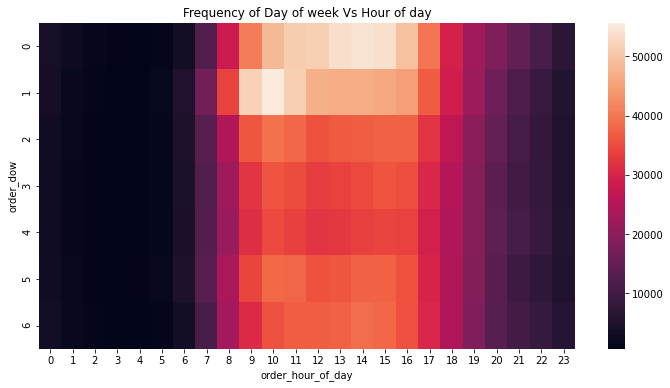

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

#### Seems like 0 and 1 (Saturday and Sunday) are when the orders are high and low during Wednesday.
#### Majority of the orders are made during day time
#### Satuday afternoon and evenings and Sunday mornings are the prime time for orders.

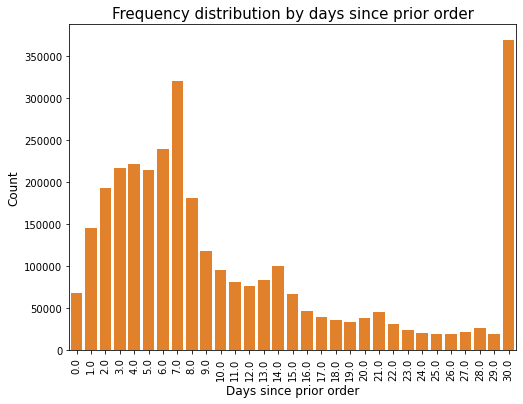

In [24]:
# time interval between the orders
plt.figure(figsize=(8,6))
sns.countplot(x="days_since_prior_order", data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

####  Customers order once in every week (7 days) or once in a month (30 days) with smaller peaks at 14, 21 and 28 days (weekly intervals).

In [25]:
# percentage of re-orders in prior set #
print("% reorders in prior set:")
print(order_products_prior.reordered.sum() / order_products_prior.shape[0])
# percentage of re-orders in train set #
print("% reorders in train set:")
print(order_products_train.reordered.sum() / order_products_train.shape[0])

% reorders in prior set:
0.5896974667922161
% reorders in train set:
0.5985944127509629


In [26]:
## % of orders when none of the products are re-ordered in prior set
grouped_df = order_products_prior.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].iloc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [27]:
## % of orders when none of the products are re-ordered in train set
grouped_df = order_products_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].iloc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

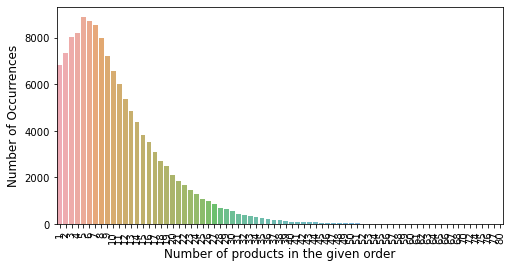

In [28]:
grouped_df = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_split = grouped_df.add_to_cart_order.value_counts()
plt.figure(figsize=(8,4))
sns.barplot(cnt_split.index, cnt_split.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### Maximum number of 5 products per order(right tailed distribution)

In [29]:
order_products_prior.shape

(32434489, 4)

In [30]:
### Merge
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


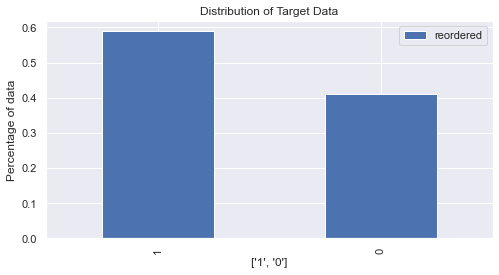

In [22]:
## Question : Target Variable Distribution ?

sns.set_theme()
plt.figure(figsize=(8,4))
grouped_df = (order_products_prior['reordered'].value_counts()/order_products_prior.shape[0]).plot.bar()
plt.xlabel(['1','0'])  # convert it to first time orders and Reorders
plt.ylabel("Percentage of data")
plt.title('Distribution of Target Data')
plt.legend()

In [37]:
order_products_train = pd.merge(order_products_train, orders, on='order_id', how='left')
prior_set = order_products_prior[order_products_prior['eval_set']=='prior']
train_set = order_products_train[order_products_train['eval_set']=='train']

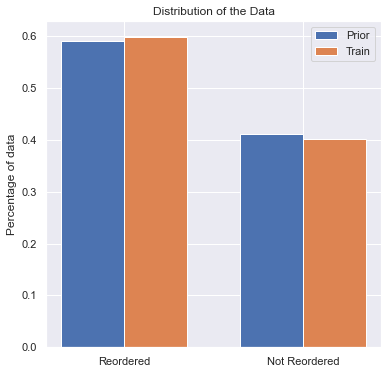

In [38]:
#plot distribution by percentage

prior_set = prior_set['reordered'].value_counts()/prior_set.shape[0]
train_set = train_set['reordered'].value_counts()/train_set.shape[0]

width = 0.35  
x = np.array([0,1])
fig, ax = plt.subplots(figsize=(6,6))
rects1 = ax.bar(x - width*0.5, prior_set, width, label='Prior')
rects2 = ax.bar(x + width*0.5, train_set, width, label='Train')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of data')
ax.set_title('Distribution of the Data')
ax.set_xticks(x)
ax.set_xticklabels(['Reordered','Not Reordered'])
ax.legend()
plt.show()

In [31]:
order_products_prior.groupby("product_name").aggregate(count = ("order_id","count")).sort_values(by="count",ascending=False).reset_index()

,product_name,count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
...,...,...
49683,Protein Granola Apple Crisp,0
49684,Water With Electrolytes,0
49685,Wasabi Cheddar Spreadable Cheese,0
49686,Ultra Sun Blossom Liquid 90 loads Fabric Enhan...,0


In [45]:
#ques : Frequently reordered product ?
#percentage - of products reordered

grouped_df = order_products_prior[order_products_prior['reordered'] ==1].groupby(['product_name'])['product_name'].size().\
        reset_index(name = 'reorder_rate').sort_values(by ='reorder_rate', ascending = False)
grouped_df['reorder_rate'] = grouped_df['reorder_rate']/order_products_prior[order_products_prior['reordered'] ==1]['order_id'].nunique()
grouped_df.set_index('product_name', inplace = True)
grouped_df.round(5)

,reorder_rate
product_name,
Banana,0.14103
Bag of Organic Bananas,0.11177
Organic Strawberries,0.07283
Organic Baby Spinach,0.06612
Organic Hass Avocado,0.06019
...,...
Gluten Free Cranberry Almond Snack Bars,0.00000
Ionic Zinc 50 mg Drops,0.00000
Coronado Cherry Air Freshener,0.00000


Text(0.5, 1.0, 'Frequently reordered product')

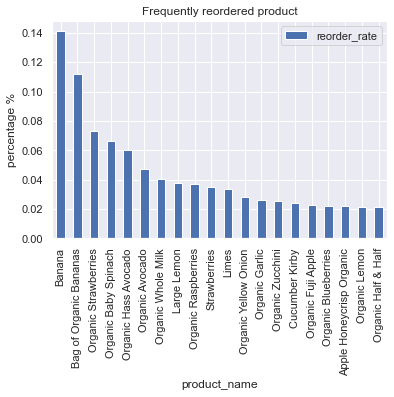

In [46]:
ax = grouped_df[:20].plot.bar()
ax.set_ylabel("percentage %")
ax.set_title('Frequently reordered product')

#### It can be seen that most of the products which are ordered and reordered are organic foods / fresh fruits (especially Bananas)
#### Bananas have highest order rate of 0.14.

In [32]:
cnt_split = order_products_prior['aisle'].value_counts().head(20)
cnt_split

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
refrigerated                      575881
frozen produce                    522654
ice cream ice                     498425
crackers                          458838
energy granola bars               456386
eggs                              452134
lunch meat                        395130
frozen meals                      390299
baby food formula                 382456
fresh herbs                       377741
Name: aisle, dtype: int64

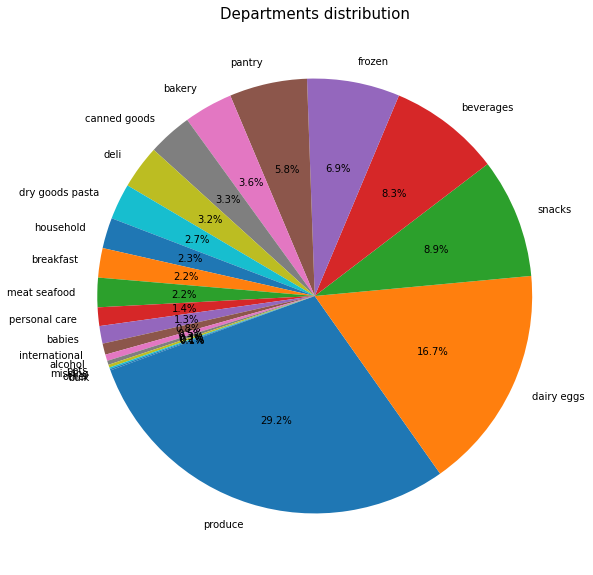

In [33]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

#### Most of the products in prior orders are organic products; also majority of them are fruits.
#### The top two aisles are fresh fruits and fresh vegetables
#### Produce is the largest department. 

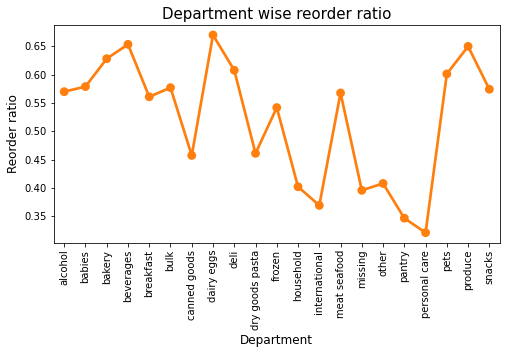

In [34]:
## Let's look at reorder ratio - department wise
grouped_df = order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(8,4))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[1])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

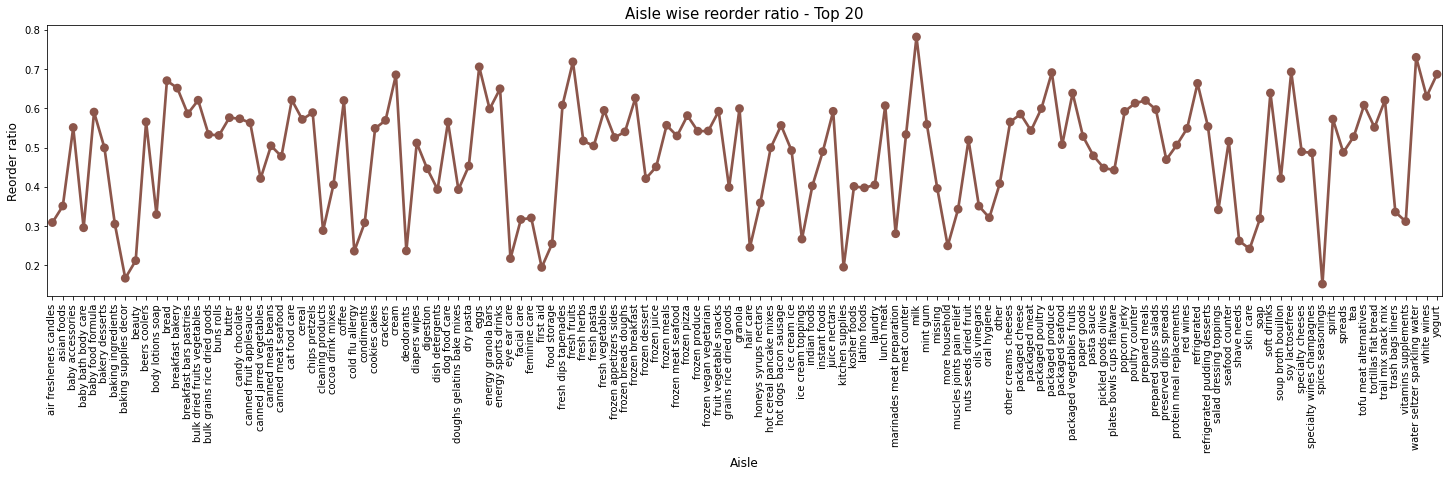

In [35]:
grouped_df = order_products_prior.groupby([ "aisle"])["reordered"].aggregate("mean").reset_index().sort_values("reordered")
plt.figure(figsize=(25,5))
sns.pointplot(grouped_df['aisle'].values, grouped_df['reordered'].values, alpha=0.8, color=color[5])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title("Aisle wise reorder ratio - Top 20", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

#### Most ordered products are from produce department which have fresh vegetables, fruits, herbs etc. But most reordered product department is dairy eggs having yogurt, milk, eegs, cheese etc.
#### We see high reorder rate in organic foods and daily consumed items.
#### Low reorder rate in personal care departments.
#### Spices seasonings has lowest reorder ratio and milk has the highest among aisles

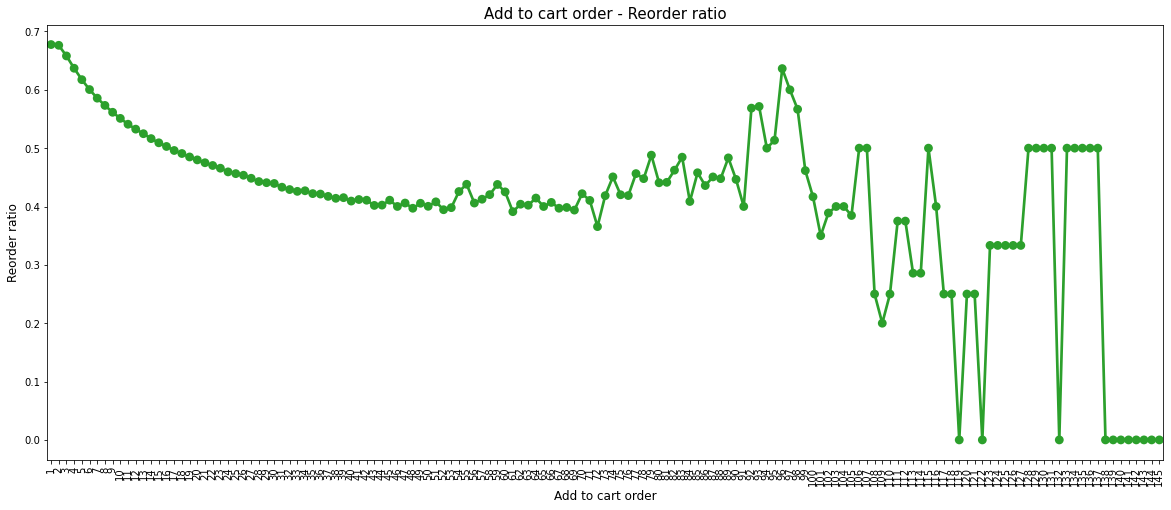

In [36]:
grouped_df = order_products_prior.groupby(["add_to_cart_order"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,8))
sns.pointplot(grouped_df['add_to_cart_order'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

#### The products which are added to the cart initially (top 10) are more likely to be reordered again compared to the ones added later. 
We see a normal decrease in reorder probability when the position of product is increased till 71.But there is huge probability changes after position is increased from 71. The lowest reorder probability is somewhere around 0.2 when position is 109. Position from 128 to 137 shows continous 50 % reorder probability. We can assume that for a product with position greater than 100 have very low probability of being reordered (below 0.3).

In [49]:
## Are there any users whose order contains only reordered products ?

grouped_df = order_products_prior.groupby(['user_id','order_id','reordered'])['reordered'].count()
grouped_df = (grouped_df / grouped_df.groupby(level=1).sum()).reset_index(name = 'reorder_prob')
grouped_df = pd.DataFrame(grouped_df[(grouped_df['reordered']==1) & (grouped_df['reorder_prob']==1.0)]['user_id'].value_counts().reset_index(name = 'count'))
grouped_df.columns = ['user_id', 'count']

#top 10 user_id with most number of orders with all reordered products
grouped_df[:10]

,user_id,count
0,99753,98
1,26489,95
2,17997,94
3,100935,94
4,69919,92
5,175680,91
6,145481,91
7,39993,90
8,127577,90
9,140753,90


#### User_id 99753 have 98 orders which contains only reordered items

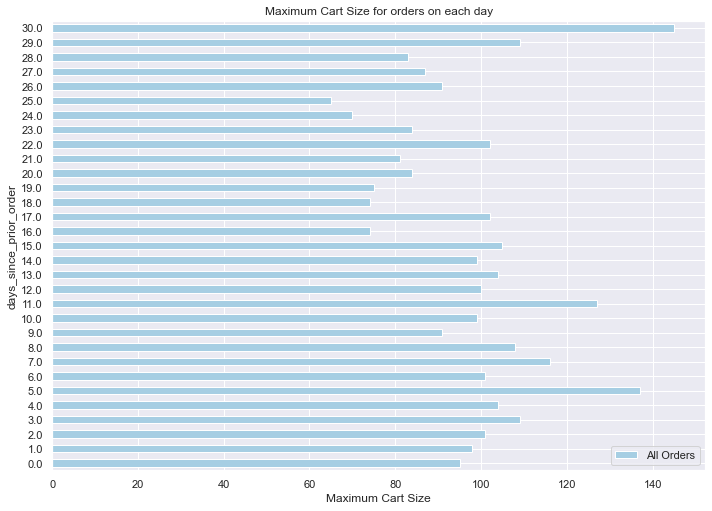

In [59]:
#ques : Average cart size after N days since prior order ?

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = order_products_prior.groupby(['days_since_prior_order'])['add_to_cart_order'].aggregate(np.max).plot(kind='barh',colormap='Paired')
ax.set_xlabel("Maximum Cart Size")
ax.set_title('Maximum Cart Size for orders on each day')
ax.legend(["All Orders"])

#### As it was expected, users with 30 days gap between consecutive orders have Largest cart size. i.e. tends to order more products



In [38]:
del cnt_split
del grouped_df

In [37]:
order_products_prior.drop(columns=["product_name","aisle_id","department_id","aisle","department"],
                          inplace=True)

In [39]:
order_products_prior.shape

(32434489, 4)

In [5]:
order_products_prior = pd.merge(order_products_prior, orders, on='order_id', how='left')

In [6]:
del orders

In [7]:
order_products_prior

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0


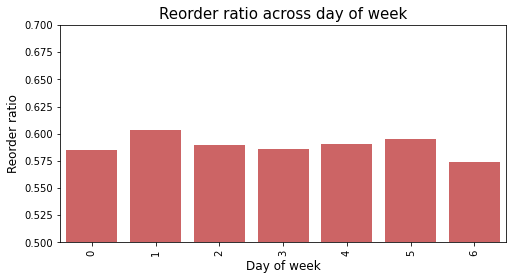

In [45]:
grouped_df = order_products_prior.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(8,4))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

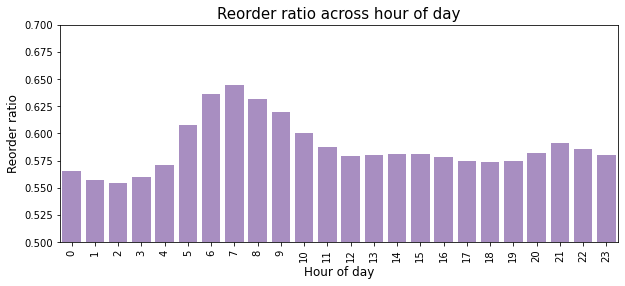

In [42]:
grouped_df = order_products_prior.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(10,4))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

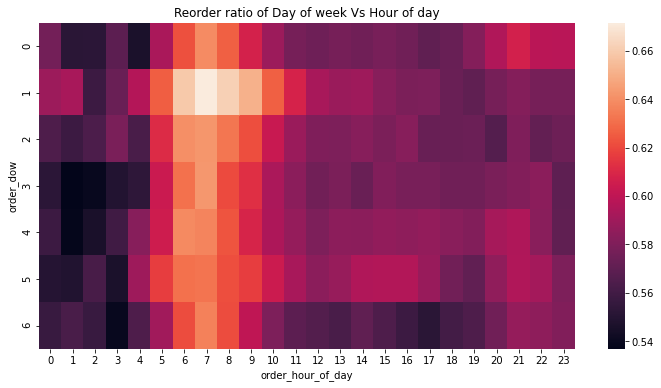

In [43]:
grouped_df = order_products_prior.groupby(
    ["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

### Reorder ratios are mostly consistent across days of the week
### Looks like reorder ratios are quite high during early mornings compared to rest of the day

In [12]:
## Association between time of last order and probability of reorder
grouped_df = order_products_prior.groupby(["days_since_prior_order"])["reordered"].mean().reset_index()

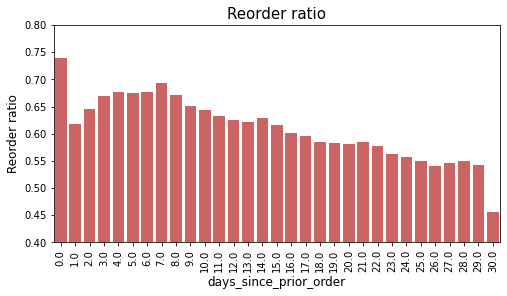

In [18]:
color = sns.color_palette()
plt.figure(figsize=(8,4))
sns.barplot(grouped_df['days_since_prior_order'].values, 
            grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('days_since_prior_order', fontsize=12)
plt.title("Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.4, 0.8)
plt.show()

#### Reordered ratio is higher if people order again on the same day and they order the same product more often. Whereas when 30 days have passed, they tend to try out new things in their order.

## Basic model - XGBoost with some feature engineering

## 2. Feature Engineering

#### Orders inner merged with OPP and has only products ordered in the prior set >> Feature engineering done on that w.r.t user_id and product_id

In [12]:
#Create a DataFrame with the orders and the products that have been purchased on prior orders (op)
#Merge the orders DF with order_products_prior by their order_id, 
#keeps only those rows with order_id which appear on both DFs since inner join
op = orders.merge(order_products_prior, on='order_id', how='inner')
op

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


In [13]:
# Number of orders per customer
# Create distinct groups for each user
# Identify the highest order number in each group, save the new column to a DataFrame
user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
# Reset the index of the DF so to bring user_id from index to column
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [14]:
#How frequent a customer has reordered products
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [15]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder

user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


In [16]:
#Number of purchases for each product
# Create distinct groups for each product, count the orders, save the result for each product to a new DataFrame  
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [18]:
p_reorder = op.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()


,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000


In [19]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder


prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


In [20]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


In [21]:
## USER * PRODUCT FEATURES

In [22]:
# Create distinct groups for each combination of user and product, count orders, 
## save the result for each user X product to a new DataFrame 
uxp = op.groupby(
    ['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
# Reset the index of the DF so to bring user_id & product_id rom indices to columns (pre-requisite for step 2.4)
uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [23]:
#last 5 orders are only looked for checking if a product will be reordered
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 

In [24]:
op5 = op[op.order_number_back <= 5]
last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last5']
last_five['times_last5_ratio'] = last_five.times_last5 / 5

In [25]:
uxp = uxp.merge(last_five , on=['user_id', 'product_id'], how='left')
del [last_five]
uxp.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio
0,1,196,10,5.0,1.0
1,1,10258,9,5.0,1.0
2,1,10326,1,NaN,NaN
3,1,12427,10,5.0,1.0
4,1,13032,3,2.0,0.4


In [26]:
uxp['times_last5'] = uxp['times_last5'].fillna(value=0)
uxp['times_last5_ratio'] = uxp['times_last5_ratio'].fillna(value=0)
uxp.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio
0,1,196,10,5.0,1.0
1,1,10258,9,5.0,1.0
2,1,10326,1,0.0,0.0
3,1,12427,10,5.0,1.0
4,1,13032,3,2.0,0.4


In [27]:
#How frequently a customer bought a product after its first purchase

In [28]:
times = op5.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                      5
        10258                    5
        12427                    5
        13032                    2
        25133                    5

In [29]:
#The total number of orders for each customer ('total_orders')
total_orders = op5.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [30]:
#Where for first_order_number we .groupby( ) by both user_id & product_id. 
#As we want to get the order when a product has been purchases for first time,
# we select the order_number column and we retrieve with .min( ) aggregation function, the earliest order.
first_order_no = op5.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,6
1,1,10258,6
2,1,12427,6
3,1,13032,7
4,1,25133,6


In [31]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,6
1,1,10,10258,6
2,1,10,12427,6
3,1,10,13032,7
4,1,10,25133,6


In [32]:
#For each product get the total orders placed since its first order ('Order_Range_D')
#The denominator now can be created with simple operations between the columns of results DataFrame:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,6,5
1,1,10,10258,6,5
2,1,10,12427,6,5
3,1,10,13032,7,4
4,1,10,25133,6,5


In [33]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,5,10,6,5
1,1,10258,5,10,6,5
2,1,12427,5,10,6,5
3,1,13032,2,10,7,4
4,1,25133,5,10,6,5


In [34]:
uxp_ratio['uxp_order_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_order_ratio
0,1,196,5,10,6,5,1.0
1,1,10258,5,10,6,5,1.0
2,1,12427,5,10,6,5,1.0
3,1,13032,2,10,7,4,0.5
4,1,25133,5,10,6,5,1.0


In [35]:
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head()

,user_id,product_id,uxp_order_ratio
0,1,196,1.0
1,1,10258,1.0
2,1,12427,1.0
3,1,13032,0.5
4,1,25133,1.0


In [36]:
#del [times, first_order_no, span,op5]

In [37]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp['uxp_order_ratio'] = uxp['uxp_order_ratio'].fillna(value=0)

In [38]:
uxp.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio
0,1,196,10,5.0,1.0,1.0
1,1,10258,9,5.0,1.0,1.0
2,1,10326,1,0.0,0.0,0.0
3,1,12427,10,5.0,1.0,1.0
4,1,13032,3,2.0,0.4,0.5


In [39]:
user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


In [40]:
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


In [41]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio
0,1,196,10,5.0,1.0,1.0,10,0.694915
1,1,10258,9,5.0,1.0,1.0,10,0.694915
2,1,10326,1,0.0,0.0,0.0,10,0.694915
3,1,12427,10,5.0,1.0,1.0,10,0.694915
4,1,13032,3,2.0,0.4,0.5,10,0.694915


In [42]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,5.0,1.0,1.0,10,0.694915,35791,0.776480
1,1,10258,9,5.0,1.0,1.0,10,0.694915,1946,0.713772
2,1,10326,1,0.0,0.0,0.0,10,0.694915,5526,0.652009
3,1,12427,10,5.0,1.0,1.0,10,0.694915,6476,0.740735
4,1,13032,3,2.0,0.4,0.5,10,0.694915,3751,0.657158


## 3a. Create train and test DataFrames

#### data contains various features on user id and product id level based on previous orders. Merging with orders_last gives us data df appended to next order_number, order_number for that user, order_dow etc., which then merged with order_products_train (on order_id and product_id) gives us details on whether that particular user_id and product_id combination was ordered in the next order (reordered:1/0) >> used for training the model. We'll then use that model to predict reordered for test set

In [43]:
orders_last = orders[(orders.eval_set=='train') | (orders.eval_set=='test') ]

In [44]:
del orders
del products
del order_products_train 
del order_products_prior 
del aisles 
del departments 

In [45]:
data = data.merge(orders_last, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,196,10,5.0,1.0,1.0,10,0.694915,35791,0.776480,1187899,train,11,4,8,14.0
1,1,10258,9,5.0,1.0,1.0,10,0.694915,1946,0.713772,1187899,train,11,4,8,14.0
2,1,10326,1,0.0,0.0,0.0,10,0.694915,5526,0.652009,1187899,train,11,4,8,14.0
3,1,12427,10,5.0,1.0,1.0,10,0.694915,6476,0.740735,1187899,train,11,4,8,14.0
4,1,13032,3,2.0,0.4,0.5,10,0.694915,3751,0.657158,1187899,train,11,4,8,14.0


In [47]:
data.shape

(13307953, 16)

In [48]:
data.to_csv("/Users/angshumanchakraborty/Desktop/instacart-market-basket-analysis/Output/data.csv")

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("/Users/angshumanchakraborty/Desktop/instacart-market-basket-analysis/Output/data.csv")
data.drop(columns=["Unnamed: 0"],inplace=True)

In [11]:
data_train = data[data.eval_set=='train']

data_train = data_train.merge(order_products_train, on=['product_id', 'order_id'], how='left' )

data_train = data_train.drop(['order_id','eval_set', 'add_to_cart_order'], axis=1)
data_train = data_train.fillna(0)
data_train.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,10,5.0,1.0,1.0,10,0.694915,35791,0.776480,11,4,8,14.0,1.0
1,1,10258,9,5.0,1.0,1.0,10,0.694915,1946,0.713772,11,4,8,14.0,1.0
2,1,10326,1,0.0,0.0,0.0,10,0.694915,5526,0.652009,11,4,8,14.0,0.0
3,1,12427,10,5.0,1.0,1.0,10,0.694915,6476,0.740735,11,4,8,14.0,0.0
4,1,13032,3,2.0,0.4,0.5,10,0.694915,3751,0.657158,11,4,8,14.0,1.0


In [12]:
data_test = data[data.eval_set=='test']
data_test = data_test.drop(['eval_set', 'order_id'], axis=1)
data_test = data_test.fillna(0)
data_test.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,order_number,order_dow,order_hour_of_day,days_since_prior_order
120,3,248,1,0.0,0.0,0.000000,12,0.625,6371,0.400251,13,5,15,11.0
121,3,1005,1,1.0,0.2,0.333333,12,0.625,463,0.440605,13,5,15,11.0
122,3,1819,3,0.0,0.0,0.000000,12,0.625,2424,0.492162,13,5,15,11.0
123,3,7503,1,0.0,0.0,0.000000,12,0.625,12474,0.553551,13,5,15,11.0
124,3,8021,1,0.0,0.0,0.000000,12,0.625,27864,0.591157,13,5,15,11.0


In [15]:
del data
del orders_last

In [16]:
data_train = data_train.set_index(['user_id', 'product_id'])
data_test = data_test.set_index(['user_id', 'product_id'])

In [17]:
data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)

In [18]:
data_train.shape

(8474661, 13)

In [20]:
data_train.to_csv("/Users/angshumanchakraborty/Desktop/instacart-market-basket-analysis/Output/data_train.csv")
data_test.to_csv("/Users/angshumanchakraborty/Desktop/instacart-market-basket-analysis/Output/data_test.csv")

## 3b. Modeling

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
#importing the necessary packages.

from sklearn.metrics import f1_score, classification_report
# from scikitplot.metrics import plot_confusion_matrix
# from scikitplot.classifiers import plot_feature_importances


In [22]:
X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered,
                                                    test_size=0.2, random_state=42)

In [77]:
param_grid = {
    "xgb__objective"         : "reg:logistic"
    ,"xgb__eval_metric"      : "logloss"
    ,"xgb__learning_rate"              : [0.01,0.05,0.1]
    ,'xgb__n_estimators'     : np.arange(10,400,50)
    ,"xgb__max_depth"        : [8, 10, 12,16,18,20]
    ,"xgb__min_child_weight" :[10,15]
    ,"xgb__gamma"            :[0.3,0.5,0.70]
}


In [86]:
param_grid = {'xgb__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'xgb__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'xgb__max_depth': [5,6,7,8,9,10,11,12,13,14],
              'xgb__n_estimators': [50,65,80,100,115,130,150],
              'xgb__reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'xgb__reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [60]:
d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

In [25]:
pipe = Pipeline(steps=[('xgb', xgb.XGBClassifier())])
xgb_model = RandomizedSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=3),
                               n_iter=200, verbose=2, n_jobs=-1,scoring = 'roc_auc')

xgb_model.fit(X_train, y_train)


In [26]:
## singular values
param_grid = {
    "xgb__objective"         : "reg:logistic"
    ,"xgb__eval_metric"      : "logloss"
    ,"xgb__learning_rate"    : 0.05
    ,'xgb__n_estimators'     : 200
    ,"xgb__max_depth"        : 8
}


In [42]:
xgb = xgb.XGBClassifier(objective='reg:logistic', parameters=param_grid, num_boost_round=10)

In [29]:
xgb.fit(X_train, y_train)

#prediction
y_pred = (xgb.predict_proba(X_val)[:, 1] >= 0.21).astype('int') #setting a threshold.

In [36]:
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_val)))
# print(classification_report(y_pred, y_val))
# plot_confusion_matrix(y_pred, y_val)

F1 Score: 0.4389650317130198


In [43]:
xgb = xgb.XGBClassifier(objective='reg:logistic', parameters=param_grid, num_boost_round=10)
## Fitting on entire data.
xgb.fit(data_train.drop(['reordered'], axis=1), data_train.reordered)

[01:31:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "parameters" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_boost_round=10,
              num_parallel_tree=None, objective='reg:logistic', ...)

In [44]:
#making prdeictions on the test dataset
y_pred_test = (xgb.predict_proba
               (data_test)[:, 1] >= 0.21).astype('int') 
#setting a threshold.

In [45]:
#saving the prediction as a new column in data_test
data_test['prediction'] = y_pred_test
data_test.head()

uxp_total_bought  times_last5  times_last5_ratio  \
user_id product_id                                                     
3       248                        1          0.0                0.0   
        1005                       1          1.0                0.2   
        1819                       3          0.0                0.0   
        7503                       1          0.0                0.0   
        8021                       1          0.0                0.0   

                    uxp_order_ratio  u_total_orders  u_reordered_ratio  \
user_id product_id                                                       
3       248                0.000000              12              0.625   
        1005               0.333333              12              0.625   
        1819               0.000000              12              0.625   
        7503               0.000000              12              0.625   
        8021               0.000000              12              0.625   

                    p_total_purchases  p_reorder_ratio  order_number  \
user_id product_id                                                     
3       248                      6371         0.400251            13   
        1005                      463         0.440605            13   
        1819                     2424         0.492162            13   
        7503                    12474         0.553551            13   
        8021                    27864         0.591157            13   

                    order_dow  order_hour_of_day  days_since_prior_order  \
user_id product_id                                                         
3       248                 5                 15                    11.0   
        1005                5                 15                    11.0   
        1819                5                 15                    11.0   
        7503                5                 15                    11.0   
        8021                5                 15                    11.0   

                    prediction  
user_id product_id              
3       248                  0  
        1005                 0  
        1819                 0  
        7503                 0  
        8021                 0

In [47]:
# Reset the index
final = data_test.reset_index()
# Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]
final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [50]:
#Creating a submission file
orders = pd.read_csv(path + 'orders.csv')
orders_test = orders.loc[orders.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [51]:
#merging our prediction with orders_test
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [55]:
#remove user_id column
final = final.drop('user_id', axis=1)
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [57]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'


In [58]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,17668 18599 21903 23650 24810 39190 43961 47766
1,1528013,8424 21903 38293
2,1376945,8309 13176 14947 27959 28465 33572 34658 35948...
3,1356845,7076 10863 11520 13176 14992
4,2161313,196 10441 11266 12427 14715 27839 37710 48142


In [59]:
sub.to_csv('/Users/angshumanchakraborty/Desktop/instacart-market-basket-analysis/Submissions/xgb_out.csv', index=False, header=True)


## Private LB Score: 0.37533
## Public score: 0.37622